In [1]:
#importing the useful libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
from scipy.stats import skew, kurtosis

C:\Users\jana\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Obtaining Dataset
* data[0] will return all the images 
* data[1] will return all the catagories

## Preprocessing
All images are converted to grayscale and normalised.

In [2]:
# This is just making a labled dataset
data = tf.keras.utils.image_dataset_from_directory("dataset",batch_size=672) 
# creates a labled dataset can change the batch size for speed and image size can be set using image_size=(100,100) 
# The batch size is just all the data so will have to make much bigger with more data as currently only have 672 items

# Iterate over the dataset to convert images to grayscale
grayscale_images = []
labels = []
for images, labels_batch in data:
    for image in images:
        
        image_np = image.numpy()
        
        # Convert each image to grayscale
        grayscale_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        grayscale_images.append(grayscale_image)
    
    labels.extend(labels_batch)
    
x_in = np.array(grayscale_images)
x_normalised = x_in/255
y_in = np.array(labels)

Found 1008 files belonging to 5 classes.


# Splitting Dataset

Splitting the data set as follows:
* 70% training data
* 15% validation data
* 15% testing data

In [3]:
#splitting dataset
X_train, X_TestAndValid, Y_train, Y_TestAndValid = train_test_split(x_normalised, y_in, test_size=0.15)
X_val, X_test, Y_val, Y_test = train_test_split(X_TestAndValid, Y_TestAndValid, test_size=0.15)

#reshaping data to include individual channel (grayscale)
X_train = tf.keras.layers.Reshape(((256, 256, 1)))(X_train)
X_val = tf.keras.layers.Reshape(((256, 256, 1)))(X_val)
X_test = tf.keras.layers.Reshape(((256, 256, 1)))(X_test)

# Building the Model

In [4]:
from tensorflow.keras.layers import Concatenate, Input, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

# Define the input shape for the images
image_input = Input(shape=(256, 256, 1))  # Assuming 256x256 grayscale images

# CNN layers
conv1 = Conv2D(16, (3, 3), 1, activation='relu')(image_input)
pool1 = MaxPooling2D()(conv1)
conv2 = Conv2D(32, (3, 3), 1, activation='relu')(pool1)
pool2 = MaxPooling2D()(conv2)
conv3 = Conv2D(16, (3, 3), 1, activation='relu')(pool2)
pool3 = MaxPooling2D()(conv3)
flatten = Flatten()(pool3)
dense1 = Dense(256, activation='relu')(flatten)

# Output layer
output_layer = Dense(5, activation='softmax')(dense1)

# Define the model with both CNN and handcrafted feature inputs
model = Model(inputs=[image_input], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary() #showing structure of model

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,697,365 (14.10 MB)

 Trainable params: 3,697,365 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# Training the data

In [5]:
logsdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logsdir) # estabilishing a log directory

In [6]:
logsdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logsdir) # estabilishing a log directory

#training model
hist = model.fit(X_train, Y_train, epochs = 7, validation_data=[X_val, Y_val])

Epoch 1/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - accuracy: 0.2496 - loss: 1.6315 - val_accuracy: 0.6357 - val_loss: 0.8383
Epoch 2/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.7842 - loss: 0.6033 - val_accuracy: 0.9147 - val_loss: 0.3192
Epoch 3/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.9706 - loss: 0.1304 - val_accuracy: 0.9767 - val_loss: 0.1148
Epoch 4/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - accuracy: 0.9950 - loss: 0.0451 - val_accuracy: 1.0000 - val_loss: 0.0225
Epoch 5/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - accuracy: 1.0000 - loss: 0.0127 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 6/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 9.3717e-04
Epoch 7/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 240ms/step - accuracy: 1.0000 - loss: 5.0463e-04 - val_accuracy: 1.0000 - val_loss: 4.2007e-04


## Performance on Training and Validation Data

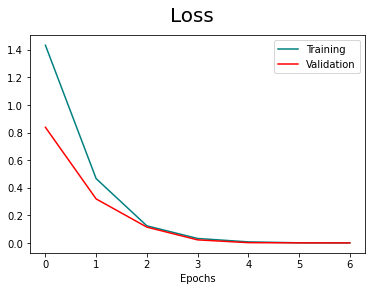

In [13]:
#hist.history
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'Training')
plt.plot(hist.history['val_loss'], color = 'red', label = 'Validation')

fig.suptitle("Loss", fontsize = 20)
plt.xlabel("Epochs")
plt.legend()
plt.show()

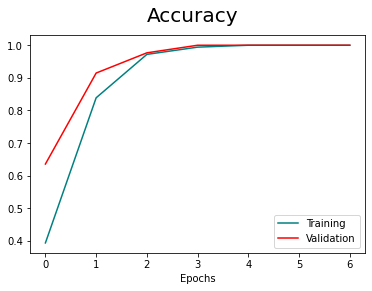

In [14]:
#hist.history
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'Training')
plt.plot(hist.history['val_accuracy'], color = 'red', label = 'Validation')

fig.suptitle("Accuracy", fontsize = 20)
plt.xlabel("Epochs")
plt.legend()
plt.show()

# Evaluation
Testing the model with the unseen test data.

In [17]:
loss, accuracy = model.evaluate(X_test, Y_test)

print("Loss: " + str(loss))
print("Accuracy: "+ str(accuracy))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 3.7743e-04
Loss: 0.0003774332581087947
Accuracy: 1.0
